# Team Project - Kickstarter Project

* Author: Julia Hammerer, Vanessa Mai
* Last Update: 15.06.2018



## Project Description
In this project we will look at a list of Crowdfunding Projects pulled from the Kickstarter website in 2018. Analysis will be mainly Data Explorations on the Project and may include (but not exclusively)
* compare successful and failed projects per country, and category
* look at size/funding amount of projects
* what's the value of successful projects, are there differences to failed ones?
* time series analysis 
* how much do people donate to projects in average

Here we will import all packages required for our analysis

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

## First Look on the data and data cleansing

Then first of all we import our csv file as a pandas dataframe


In [2]:
ks_raw=pd.read_csv("ks-projects-201801.csv")

In [3]:
ks_raw

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


When looking at the data we see that there are several fields with amounts (=pledged). The fields "pledged" and "goal" are in the original currency. There is also "usd pledged", usd_pledged_real", "uds_goal_real". "usd pledged" is the amount converted to us-dollar by Kickstarter. According to the description from Kaggle "usd_pledged_real" and "usd_goal_real" are converted using fixer.io by tonyplaysguitar. 
We'll use these fields, as this also have the "goal" in US-Dollars and we remove the other columns


In [4]:
# remove unused columns, we don't need name and id, and the mentioned amounts
# we also do not need currency, as we have everything in US-Dollar
ks=ks_raw.drop(["ID", "name", "goal", "pledged", "usd pledged", "currency"], axis=1)

# we take a look at the datatypes, to look if we need to convert any fields to the appropriate data type
ks.dtypes 

category             object
main_category        object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

We see that all the fields, that we need in a numeric form, are already automatically detected by python as numeric. 
However, to use the dates correctly, we need to convert launched and deadline into a datetime-datatype

In [5]:
ks["launched"] = pd.to_datetime(ks["launched"], infer_datetime_format=True)
ks["deadline"] = pd.to_datetime(ks["deadline"], infer_datetime_format=True)

In [6]:
# check for open projects
closed=ks["deadline"]>ks["launched"]
closed.value_counts()

True    378661
dtype: int64

We see that we only have closed projects here. As a prospect, we could include open projects and do a prediction on whether a project will be successful or not. Next step is to look at the data more closely and see some basic information on the data. For this we use the package pandas-profiling. See documenation [here](https://github.com/pandas-profiling/pandas-profiling)


In [7]:
import pandas_profiling

In [8]:
pandas_profiling.ProfileReport(ks)

Number of variables,9
Number of observations,378661
Total Missing (%),0.0%
Total size in memory,26.0 MiB
Average record size in memory,72.0 B
Numeric,3
Categorical,4
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [9]:
# We also look at some other descriptive statistics
ks.describe()

,backers,usd_pledged_real,usd_goal_real
count,378661.000000,3.786610e+05,3.786610e+05
mean,105.617476,9.058924e+03,4.545440e+04
std,907.185035,9.097334e+04,1.152950e+06
min,0.000000,0.000000e+00,1.000000e-02
25%,2.000000,3.100000e+01,2.000000e+03
50%,12.000000,6.243300e+02,5.500000e+03
75%,56.000000,4.050000e+03,1.550000e+04
max,219382.000000,2.033899e+07,1.663614e+08


So we have a basic summary first. The data seems to be complete, there are no missing values, so we do not have to deal with that. However, if we look closely at **"launched"**, which is the launch-day of a product, we can see that there are some in 1970. These might be missing values, so we have to think about what to do with that. As we have plenty records (~380 000) and the number of those observations are relatively low, it is enough if we just remove those observations

Another thing is, that the cardinality of **"category"** is very high, meaning there are many different values. If in the end, the number of observations per category is too small, it might not make much sense to explore them further. We will elaborate on that later more closely.

The **countries** are only displayed with their country code. We need to convert them to proper country names for better readability, later on also possibly some geocoding, and thus using maps for visualizations and such things. We will also elaborate on that later.

Pandas_Profiling also provides a really quick **Correlation Analysis**. We can see a high positive correlation between backers und pledged amount, which makes perfect sense, so this does not give us particularly interesting information. In fact, it is more interesting to see the average amount that backers give for the projects. Thus, we'll look into this later.

In [10]:
## remove the rows with launched in 1970, as these are default values for missing entries
ks = ks[(ks["launched"].dt.year > 1970)]

We need to map the country code to the proper country names for better readability. Thus, we're using a file that includes the 2-digits code and the country name and we use this for mapping (file found [here](https://datahub.io/core/country-list#resource-data))

In [11]:
# read in a mapping file for countries
country_mapping=pd.read_csv("country.csv")

In [12]:
country_mapping

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS
5,Andorra,AD
6,Angola,AO
7,Anguilla,AI
8,Antarctica,AQ
9,Antigua and Barbuda,AG


In [13]:
# we'll do a left outer join, with our Kickstarter-Projectlist being left
ks= pd.merge(ks,country_mapping, how="left", left_on="country", right_on="Code" )

# we can see that the names are now properly written out
# but we'll need to remove the joining columns and rename the Country column from "Name" to "Country"
ks= ks.drop(["country", "Code"], axis=1)
ks=ks.rename(columns={"Name": "Country"})
ks.tail()

,category,main_category,deadline,launched,state,backers,usd_pledged_real,usd_goal_real,Country
378649,Documentary,Film & Video,2014-10-17,2014-09-17 02:35:30,canceled,1,25.0,50000.0,United States
378650,Narrative Film,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,155.0,1500.0,United States
378651,Narrative Film,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,20.0,15000.0,United States
378652,Technology,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,200.0,15000.0,United States
378653,Performance Art,Art,2011-08-16,2011-07-19 09:07:47,failed,17,524.0,2000.0,United States


In [14]:
# let's have a look at which countries we have:
print(ks.Country.unique())

['United Kingdom' 'United States' 'Canada' 'Australia' 'Norway' 'Italy'
 'Germany' 'Ireland' 'Mexico' 'Spain' nan 'Sweden' 'France' 'Netherlands'
 'New Zealand' 'Switzerland' 'Austria' 'Denmark' 'Belgium' 'Hong Kong'
 'Luxembourg' 'Singapore' 'Japan']


We can see, that there is also "nan", so we had values which could not be mapped. We also looked into the raw data and saw the value "N,0"". This seems like a data quality issue. We can either remove the data or leave it in with the country value missing. 
We'll look into how many there are, if it is not too much, we can just remove it:

In [15]:
# How many are "missing" in Country
print((ks.Country.isna()).sum())

3797


232 out of more than 300 000 is not much, so we can remove them without much concern.

In [16]:
# remove of nan rows in Country
ks = ks[(ks["Country"].notna())]

## Distributions

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Distribution of Project Status
First we take a look at the distribution of the status of the Projects


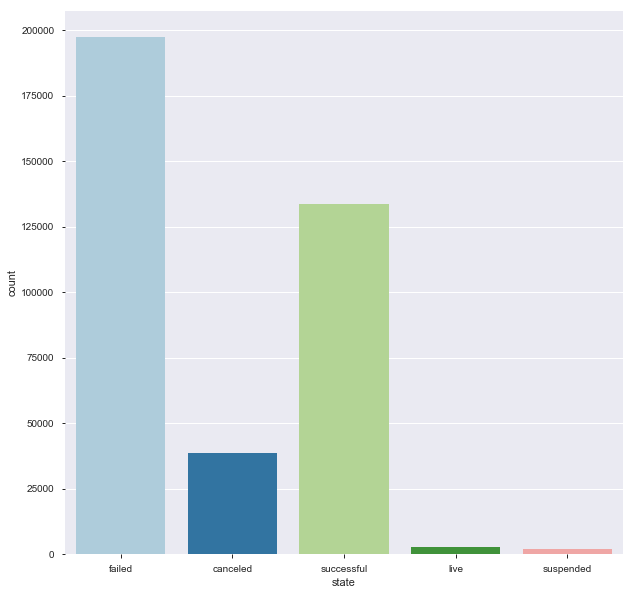

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.countplot(x="state",data=ks, ax=ax,palette="Paired")


In this plot the number of projects and their respective status are displayed.
We can see that most Projects have failed. The values "live", "undefined" and "suspended" have the least values and their status is not clear, there is no proper description on the source of the data (Kaggle) either. So these values will be removed in the next step. We concentrate on the more meaningful values "failed", "canceled" and "successful"
Next we analyse the rate of success.

In [19]:
# Removing Rows
ks= ks[ks.state != "live"]
ks= ks[ks.state != "undefined"]
ks= ks[ks.state != "suspended"]

In [20]:
# Success rate
success_rate = (ks.state == 'successful').sum()/len(ks.index)
print(success_rate)

0.36154839337035677


Rougly 36% of all Projects, this dataset are won. 
As one of the next steps, we try to find out differences between failed and cancelled.

### Distribution of the Main Category

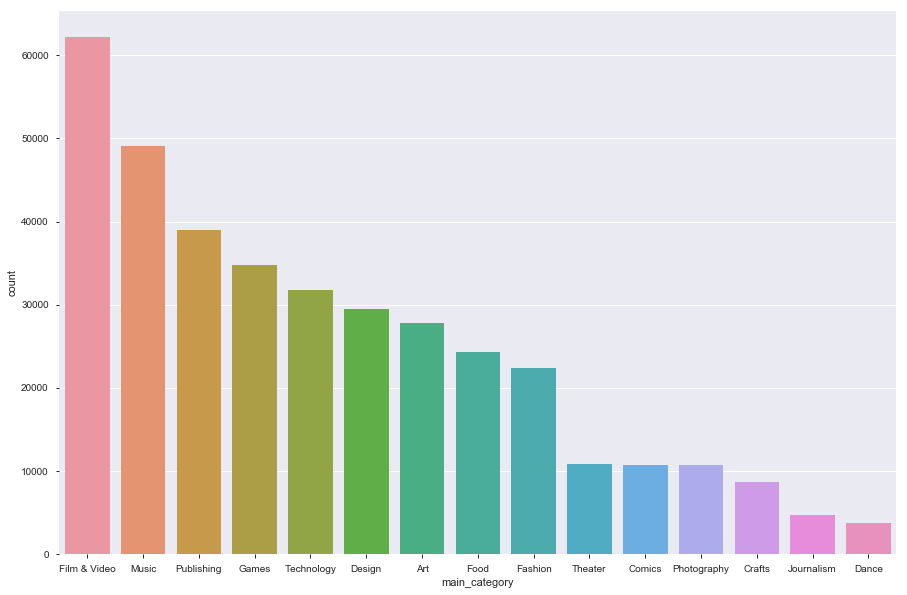

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="main_category",data=ks, ax=ax, order = ks['main_category'].value_counts().index)

We have a deeper look at the distribution of categories and main categories

In [22]:
ks.groupby("main_category")["category"].value_counts()


main_category  category         
Art            Art                  8154
               Painting             3263
               Illustration         3125
               Public Art           3060
               Mixed Media          2734
               Performance Art      2141
               Sculpture            1803
               Digital Art          1329
               Conceptual Art       1016
               Installations         471
               Ceramics              302
               Textiles              274
               Video Art             190
Comics         Comics               4973
               Comic Books          2707
               Graphic Novels       1839
               Webcomics             643
               Anthologies           402
               Events                156
Crafts         Crafts               4603
               Woodworking          1150
               DIY                  1126
               Candles               427
               Printing 

 How is the distribution of failed,canceld or successful Projects in each category?

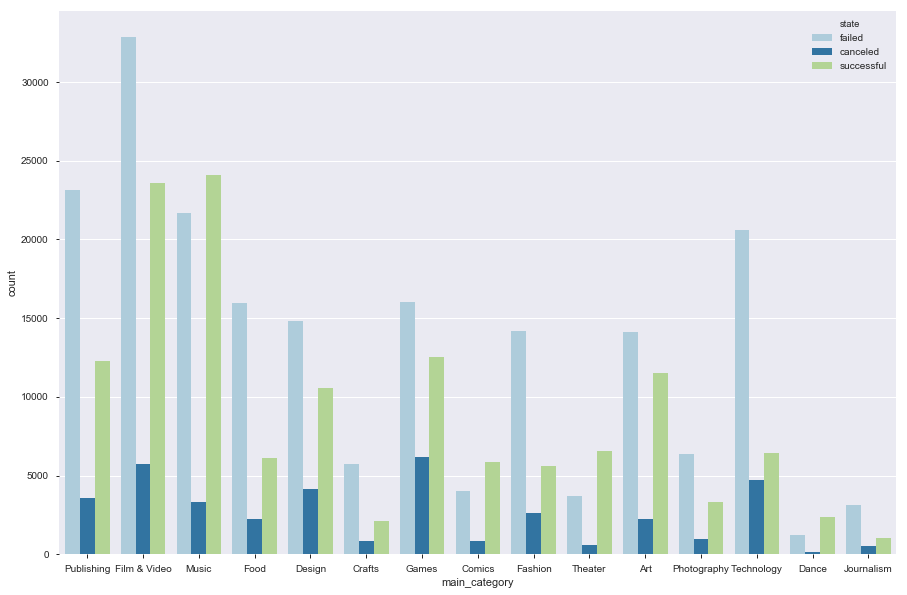

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="main_category",hue="state",data=ks, ax=ax, palette="Paired")

How many entries in the dataset are from which country?

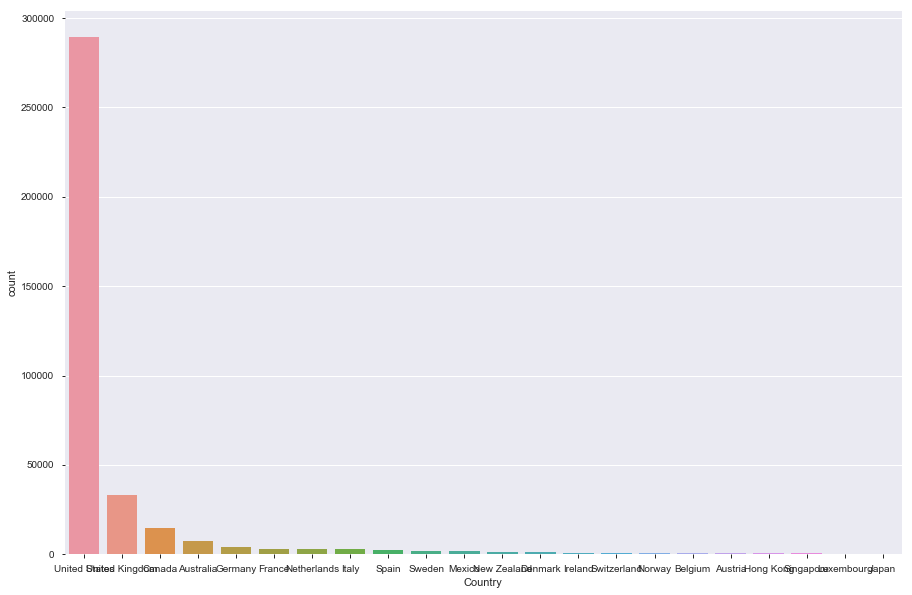

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="Country",data=ks,order = ks['Country'].value_counts().index,ax=ax)

### Distribution of the Project state across the countries

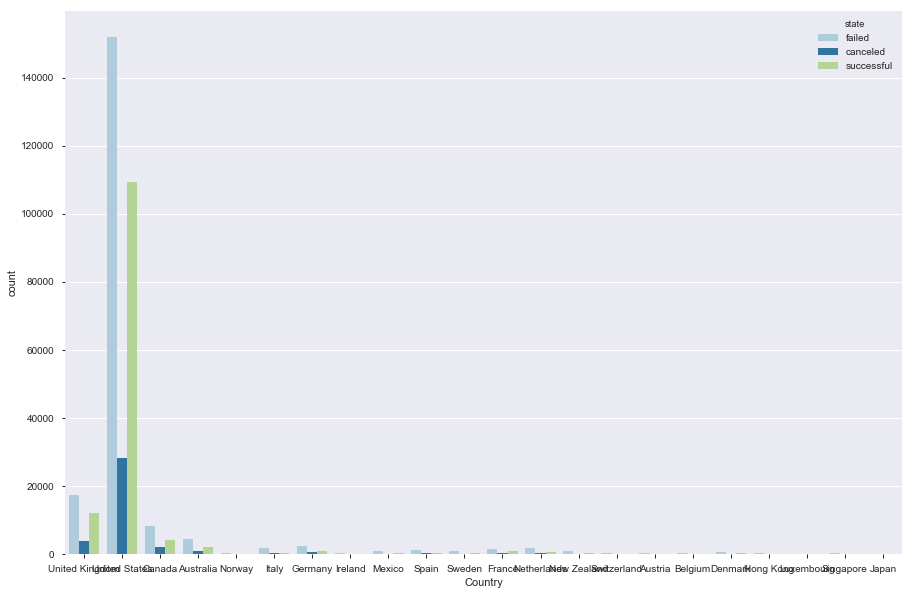

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="Country",hue="state",data=ks, ax=ax, palette="Paired")

### How many backers do the projects have in each country?

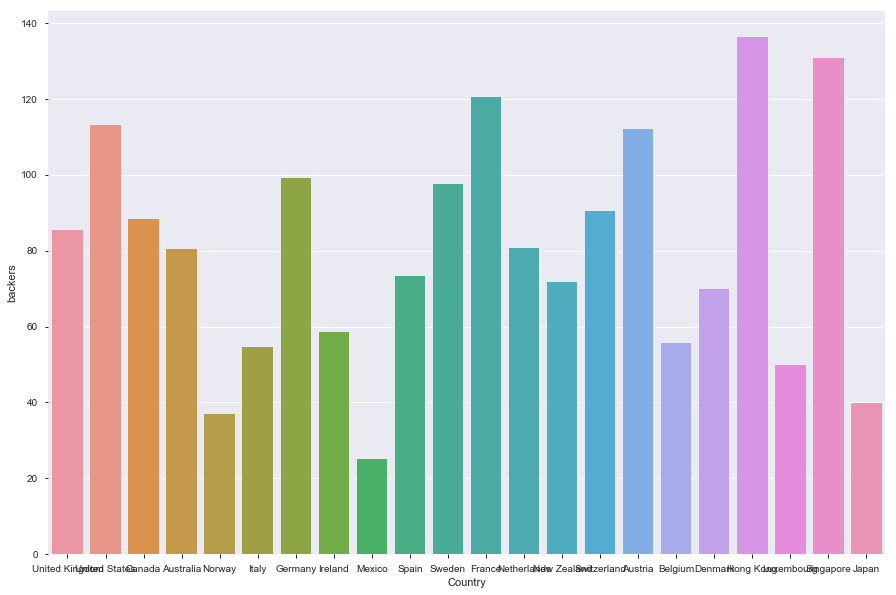

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.barplot(x="Country",y="backers",data=ks,ci=None, ax=ax)
plt.show()

In [27]:
print("Minimal goal value:", ks["usd_goal_real"].min())
print("Mean goal value:", ks["usd_goal_real"].mean())
print("Maximum goal value:", ks["usd_goal_real"].max())

Minimal goal value: 0.01
Mean goal value: 45092.60043542148
Maximum goal value: 166361390.71


## Project Sizes
After having a look at various counts of the Projects, we need to see the sizes of those projects. 
e.g. What are the goals of the projects in various categories?


{'whiskers': [<matplotlib.lines.Line2D at 0x227cab0bef0>,
 'caps': [<matplotlib.lines.Line2D at 0x227cab18860>,
 'boxes': [<matplotlib.lines.Line2D at 0x227cab0bd68>],
 'medians': [<matplotlib.lines.Line2D at 0x227cab20160>],
 'fliers': [<matplotlib.lines.Line2D at 0x227cab205c0>],
 'means': []}

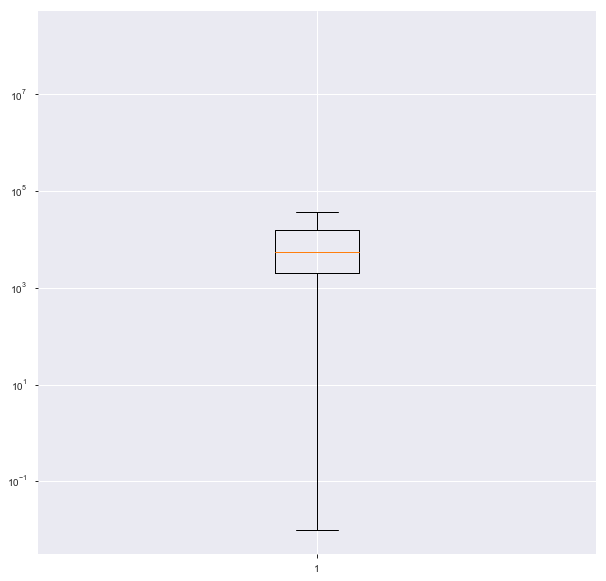

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.yscale("log")
# plt.xscale("log")

plt.boxplot(ks.usd_goal_real)
# sns.distplot(x, kde=False, rug=True);

In the first histogram showing the goal of the projects in the Profile Report, we don't see much. We only saw, that the USD_goal is highly skewed. Here, we produced a boxplot with a logarithmic scale to see the data better. The biggest fraction of all projects' goals are between **1000** and **100000**. Let's create another histogram for those projects to see the distribution within that fraction better. 

In [29]:
ks_small = ks[((ks["usd_goal_real"]<100000) & (ks["usd_goal_real"]>1000)) ]
print(len(ks_small.index))
print(len(ks.index))


294393
370216


C:\Users\maiv2\AppData\Local\Continuum\anaconda3\envs\condadatascience\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


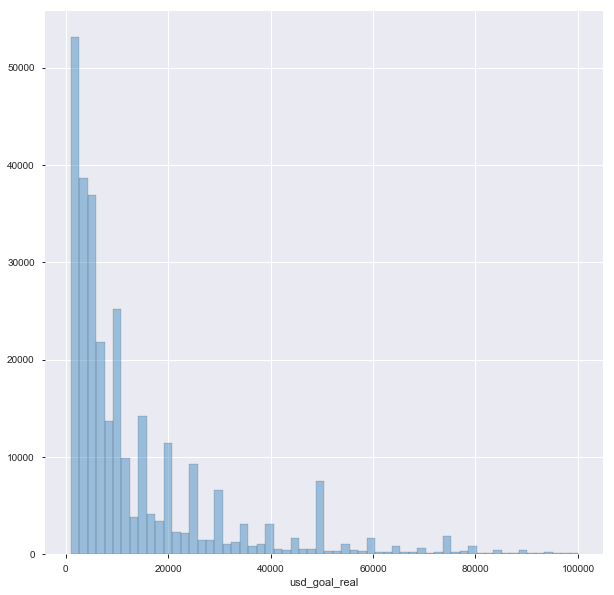

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
# plt.yscale("log")
# plt.xscale("log")
plt.rcParams["patch.force_edgecolor"] = True


sns.distplot(ks_small.usd_goal_real, bins=60, kde = False, hist_kws=dict(edgecolor="black"))
# sns.distplot(x, kde=False, rug=True);

plt.show()

In [64]:
from pandas import Timestamp


In [65]:
from ggplot import *

ImportError: cannot import name 'Timestamp'

### Project Sizes per Main Category
We want to also see if there are bigger differences between the different main categories. As, the categories have a very high cardinality, we don't look at it at this point.

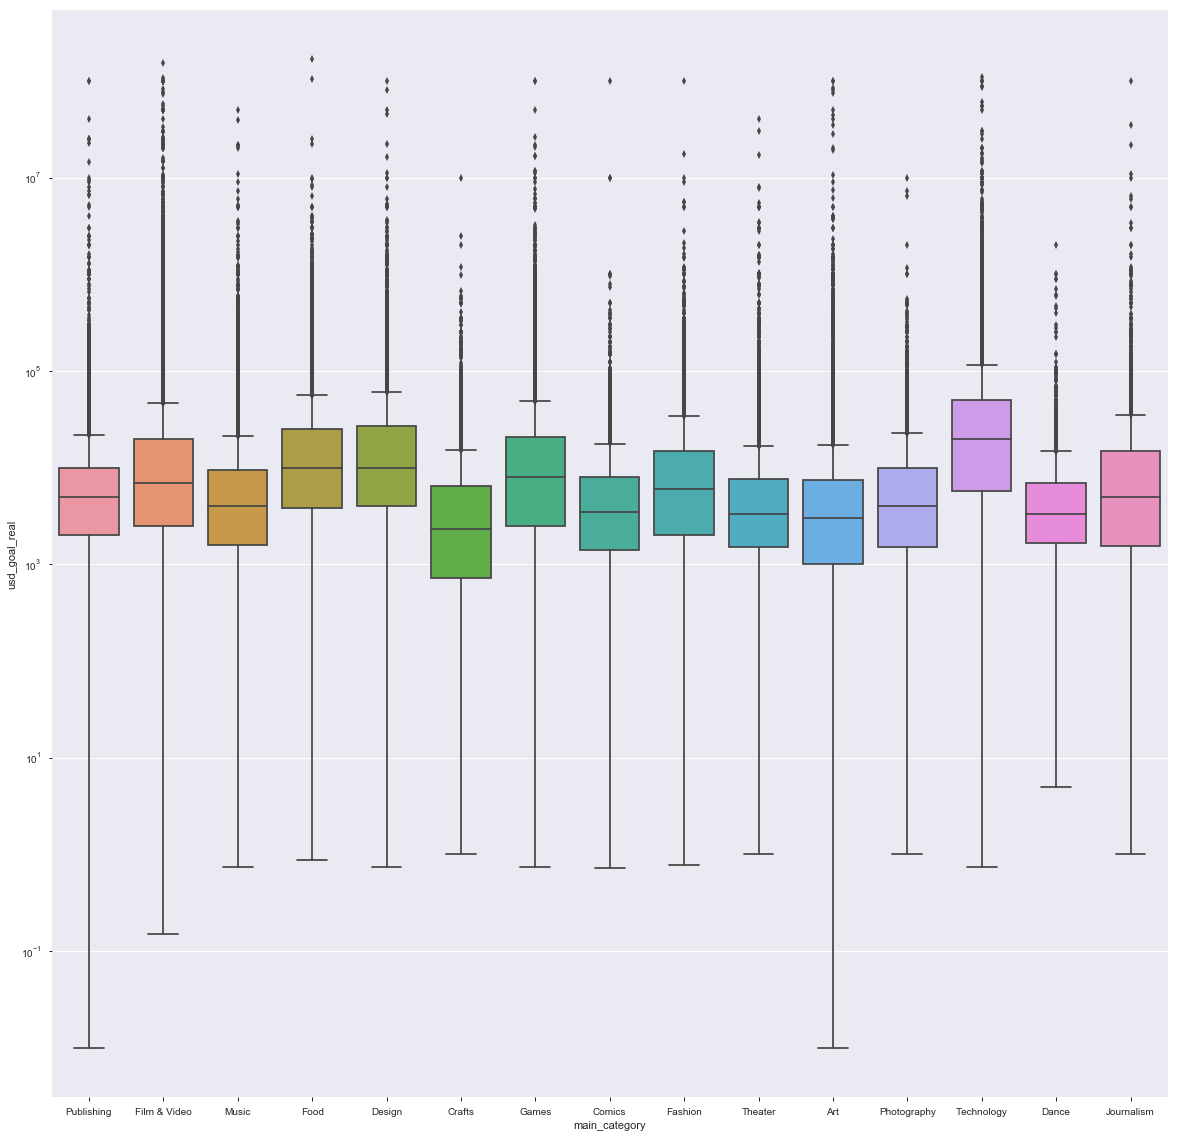

In [31]:
plt.figure(figsize=(20,20))
plt.yscale("log")
sns.boxplot(x="main_category", y="usd_goal_real",data=ks)


In this plot, we can see more clearly the outliers of the main categories, which are existing in any main category. In general, we see that the range stays in around the same amount, with only "Technology" slightly sticking out for having higher goals. In "Publishing" and "Art" there are also projects with a very low goal. In summary, "Publishing", "Crafts" and "Art" have slightly lower goals, whereas "Technology" requires most donations. As the other plots, this is also on a logarithmic scale. 



### Project Sizes per Country
Also, interesting would be to see if there are differences by counties:


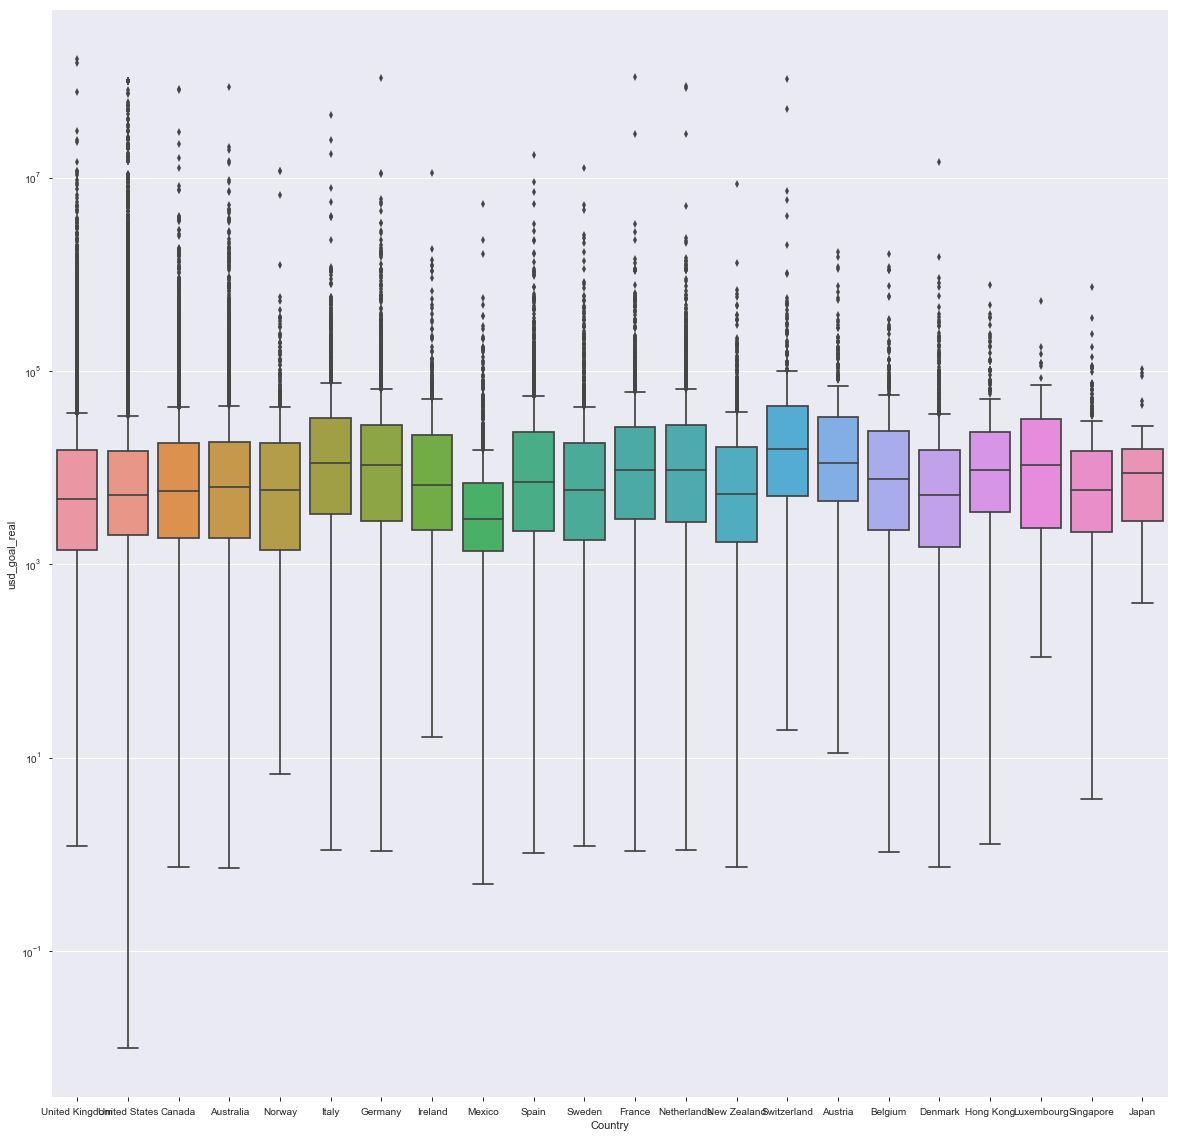

In [32]:
plt.figure(figsize=(20,20))
plt.yscale("log")
sns.boxplot(x="Country", y="usd_goal_real",data=ks)


There isn't much variation between the countries, except for US having some particularly low goals for some project. This isn't surprising though, as most projects come from USA.

We want to see the average, median, and possibly other basic statistics for each category and country.

In [33]:
ks[["main_category", "usd_goal_real"]].groupby("main_category").describe().sort_values(by= ('usd_goal_real', 'mean'), ascending =False)

usd_goal_real                                               \
                      count           mean           std   min       25%   
main_category                                                              
Technology          31761.0  102059.279094  1.578811e+06  0.74  5690.480   
Film & Video        62246.0   82419.052421  1.732934e+06  0.15  2500.000   
Journalism           4671.0   65538.981353  1.608372e+06  1.00  1530.480   
Food                24263.0   48663.584534  1.290337e+06  0.88  3860.200   
Games               34720.0   45148.670549  8.687356e+05  0.75  2500.000   
Design              29514.0   42201.779374  8.731598e+05  0.75  4000.000   
Art                 27862.0   39468.501476  1.318571e+06  0.01  1000.000   
Theater             10849.0   27149.584643  5.396899e+05  1.00  1500.000   
Publishing          39014.0   22605.780995  7.978442e+05  0.01  2000.000   
Fashion             22424.0   22529.894330  6.895487e+05  0.77  2000.000   
Comics              10720.0   19675.773316  9.757182e+05  0.72  1400.000   
Music               49100.0   15755.820804  3.599575e+05  0.74  1600.000   
Photography         10675.0   12266.908892  1.397108e+05  1.00  1500.000   
Crafts               8661.0   10423.092597  1.174641e+05  1.00   720.430   
Dance                3736.0    9408.592117  5.208567e+04  5.00  1675.465   

                                                 
                    50%       75%           max  
main_category                                    
Technology     20000.00  50000.00  1.101698e+08  
Film & Video    7000.00  20000.00  1.513959e+08  
Journalism      5000.00  14999.50  1.000000e+08  
Food           10000.00  25000.00  1.663614e+08  
Games           8000.00  20840.17  1.000000e+08  
Design         10000.00  26855.17  1.000000e+08  
Art             3000.00   7500.00  1.000000e+08  
Theater         3300.00   7554.24  4.000000e+07  
Publishing      5000.00  10000.00  1.000000e+08  
Fashion         5982.53  15000.00  1.000000e+08  
Comics          3500.00   8000.00  1.000000e+08  
Music           4000.00   9500.00  5.000000e+07  
Photography     4000.00  10000.00  1.000000e+07  
Crafts          2330.35   6500.00  1.000000e+07  
Dance           3310.00   7000.00  2.000000e+06

In [34]:
ks[["Country", "usd_goal_real"]].groupby("Country").describe().sort_values(by= ('usd_goal_real', 'mean'), ascending =False)

usd_goal_real                                                  \
                       count           mean           std     min        25%   
Country                                                                        
Switzerland            736.0  279174.858519  4.294198e+06   19.41  5147.7825   
Netherlands           2807.0  110342.865525  2.374129e+06    1.10  2715.0000   
France                2873.0   82490.028065  2.126092e+06    1.09  2913.5200   
Italy                 2775.0   80129.270753  1.045905e+06    1.10  3290.9900   
Germany               4057.0   76055.615201  1.717983e+06    1.08  2817.0000   
Norway                 694.0   68465.573660  6.824179e+05    6.81  1420.0150   
Australia             7681.0   58668.777448  1.103118e+06    0.72  1867.5900   
Spain                 2204.0   53712.774868  4.751873e+05    1.04  2231.6925   
Ireland                793.0   47669.411753  4.176204e+05   16.28  2276.1900   
Canada               14508.0   44191.568766  1.026956e+06    0.74  1884.4475   
Austria                576.0   44094.737049  1.330018e+05   11.28  4466.0825   
United Kingdom       33215.0   43002.410805  1.346118e+06    1.22  1412.8200   
United States       289665.0   42961.060877  1.063749e+06    0.01  2000.0000   
Sweden                1718.0   41426.026234  3.694921e+05    1.22  1764.2200   
Belgium                597.0   37545.977353  1.282300e+05    1.06  2265.2100   
Denmark               1083.0   36347.112235  4.455053e+05    0.74  1497.9200   
Luxembourg              61.0   34237.490984  7.551559e+04  109.39  2396.6600   
New Zealand           1425.0   24794.035305  2.326934e+05    0.75  1722.2400   
Hong Kong              564.0   24455.373723  5.644391e+04    1.28  3463.9775   
Japan                   31.0   19103.641613  2.836378e+04  394.94  2806.1000   
Singapore              521.0   15542.610518  4.164754e+04    3.73  2137.2100   
Mexico                1632.0   15030.582941  1.507822e+05    0.49  1372.8000   

                                                     
                      50%         75%           max  
Country                                              
Switzerland     15417.030  43633.4100  1.040572e+08  
Netherlands      9494.420  27698.7250  8.876757e+07  
France           9507.960  26102.2800  1.101698e+08  
Italy           11090.040  32498.8750  4.433607e+07  
Germany         10580.000  27739.8700  1.073699e+08  
Norway           5866.270  18118.9675  1.179593e+07  
Australia        6361.320  18570.1000  8.709284e+07  
Spain            7105.795  23484.1000  1.710454e+07  
Ireland          6680.990  21751.9000  1.121504e+07  
Canada           5739.265  17979.4900  8.262414e+07  
Austria         11280.950  33538.3950  1.683899e+06  
United Kingdom   4738.790  15391.2500  1.663614e+08  
United States    5250.000  15000.0000  1.000000e+08  
Sweden           5903.565  18090.5450  1.264302e+07  
Belgium          7645.430  24119.9200  1.637108e+06  
Denmark          5205.390  15147.5150  1.446132e+07  
Luxembourg      10617.840  31695.0500  5.315982e+05  
New Zealand      5286.610  16326.0000  8.521517e+06  
Hong Kong        9497.720  23194.3850  7.735847e+05  
Japan            8823.790  15493.4600  1.058574e+05  
Singapore        5898.400  14958.8600  7.354563e+05  
Mexico           2956.735   6963.2350  5.289326e+06

## Success Chances and Rates

After seeing the distributions and values of the projects and having a feeling about the data, we want to see, what the success rates are and see if any attributes have any significant correlation with the outcome of the project. In the following, we will conduct some univariate analysis.

First we want to add some more interesting values
* Duration of the project: How much time between launch-day and deadline in days?
* Delta pledged: how much more than the goal has been pledged or how much is missing?
* Average pledged per backer: how much in average do people donate per project?
* pledged rate: How much per day in average?

In [36]:
ks["project_length"]=(ks["deadline"]-ks["launched"])/np.timedelta64(1, 'D')
ks["pledged_delta"]= ks["usd_pledged_real"]-ks["usd_goal_real"]
ks["pledged_per_backer"]=ks["usd_pledged_real"]/ks["backers"]
ks["pledged_per_day"]= ks["project_length"]/ks["usd_pledged_real"]

In [37]:
ks.head()

,category,main_category,deadline,launched,state,backers,usd_pledged_real,usd_goal_real,Country,project_length,pledged_delta,pledged_per_backer,pledged_per_day
0,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,0.0,1533.95,United Kingdom,58.491343,-1533.95,NaN,inf
1,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,2421.0,30000.00,United States,59.802813,-27579.00,161.400000,0.024702
2,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,220.0,45000.00,United States,44.985532,-44780.00,73.333333,0.204480
3,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,1,1.0,5000.00,United States,29.858206,-4999.00,1.000000,29.858206
4,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,1283.0,19500.00,United States,55.642326,-18217.00,91.642857,0.043369


First we look into the distribution of the project length. 

C:\Users\maiv2\AppData\Local\Continuum\anaconda3\envs\condadatascience\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


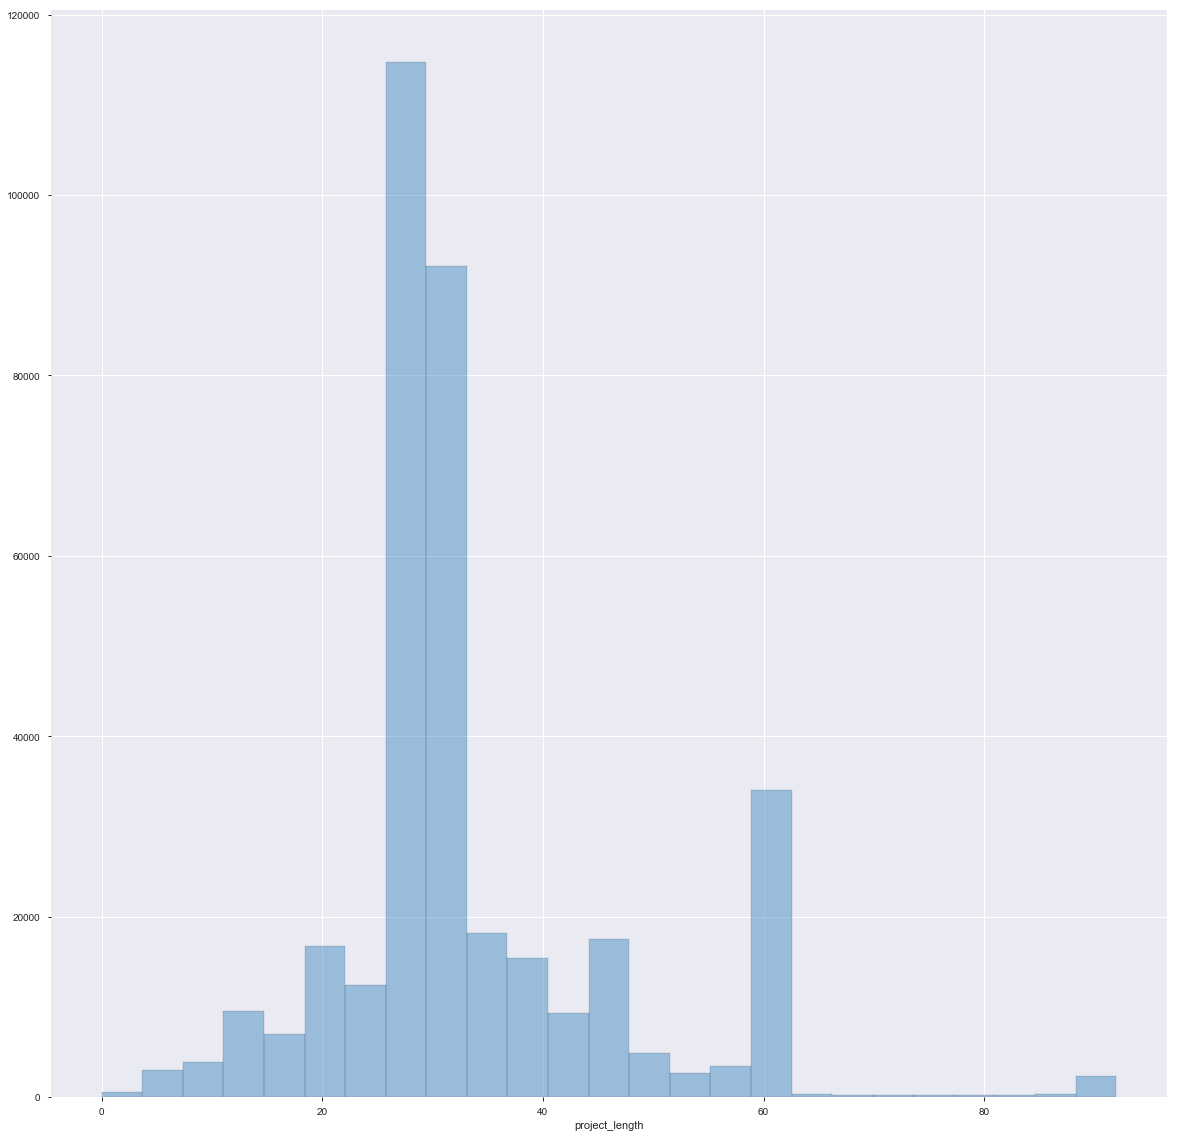

In [42]:
plt.figure(figsize=(20,20))
sns.distplot(ks.project_length, bins=25, kde = False, hist_kws=dict(edgecolor="black"))


We see a nicely shaped distribution, with most projects having a length of approximately 30 days/ 1 month. There is another smaller peak at 60 days/ 2 months.

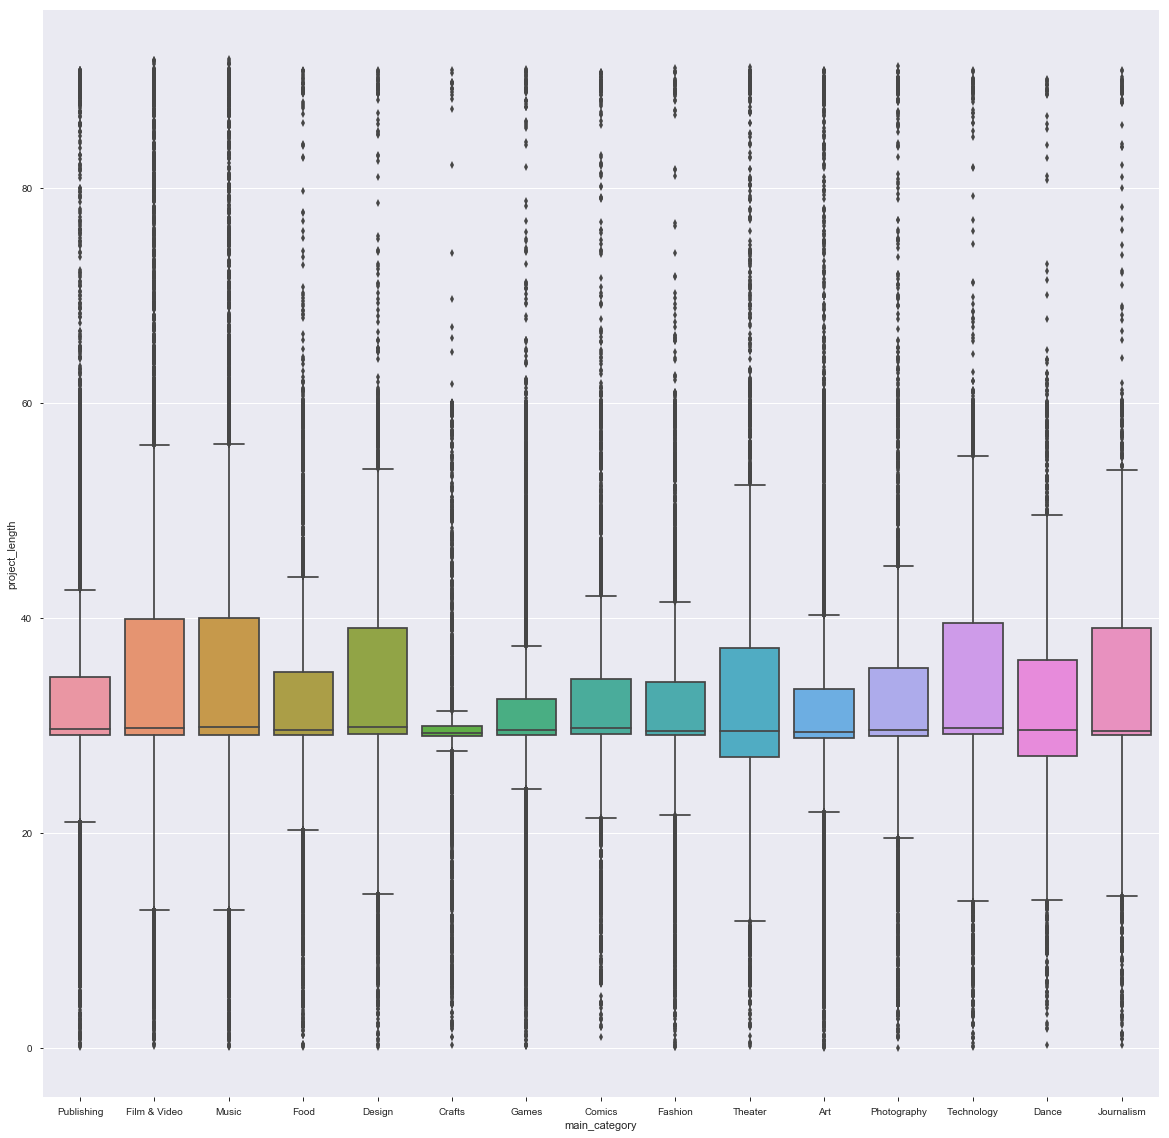

In [44]:
plt.figure(figsize=(20,20))
sns.boxplot(x="main_category", y="project_length",data=ks)


Next we look into how the project length vary for successful, cancelled and failed projects.

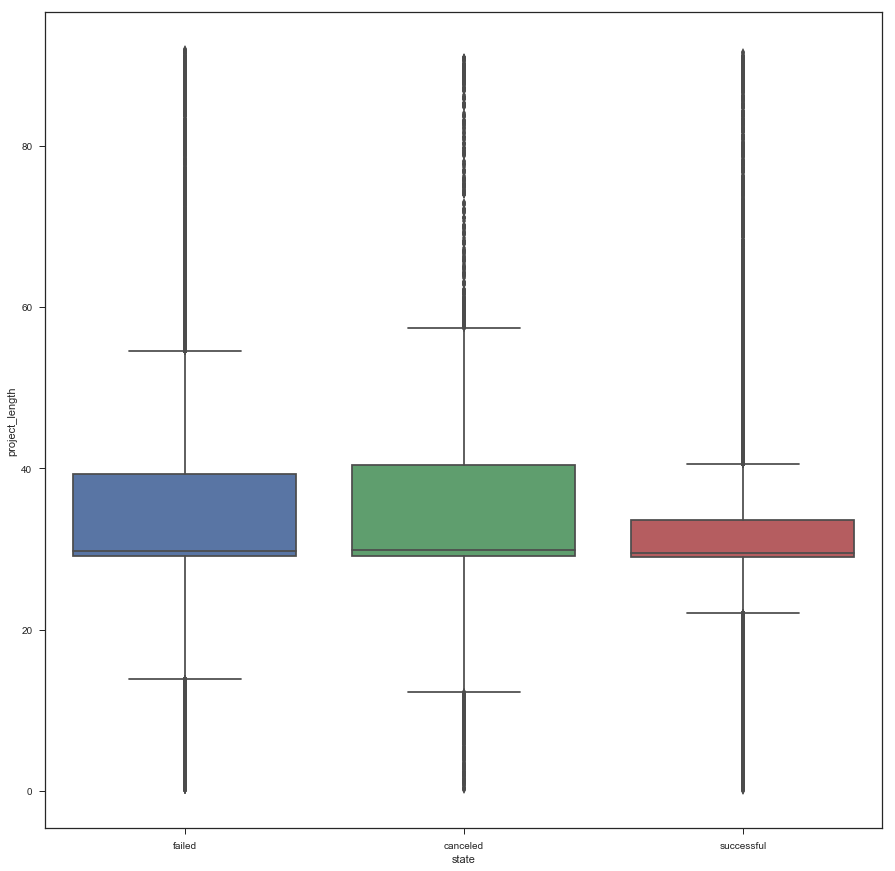

In [51]:
plt.figure(figsize=(15,15))
sns.boxplot(x="state", y="project_length",data=ks)


Even though the median looks the same for all three states, successful projects seems to have shorter deadlines. They are less skewed, even though there are still many outliers. 

We'll look into the different categories again:

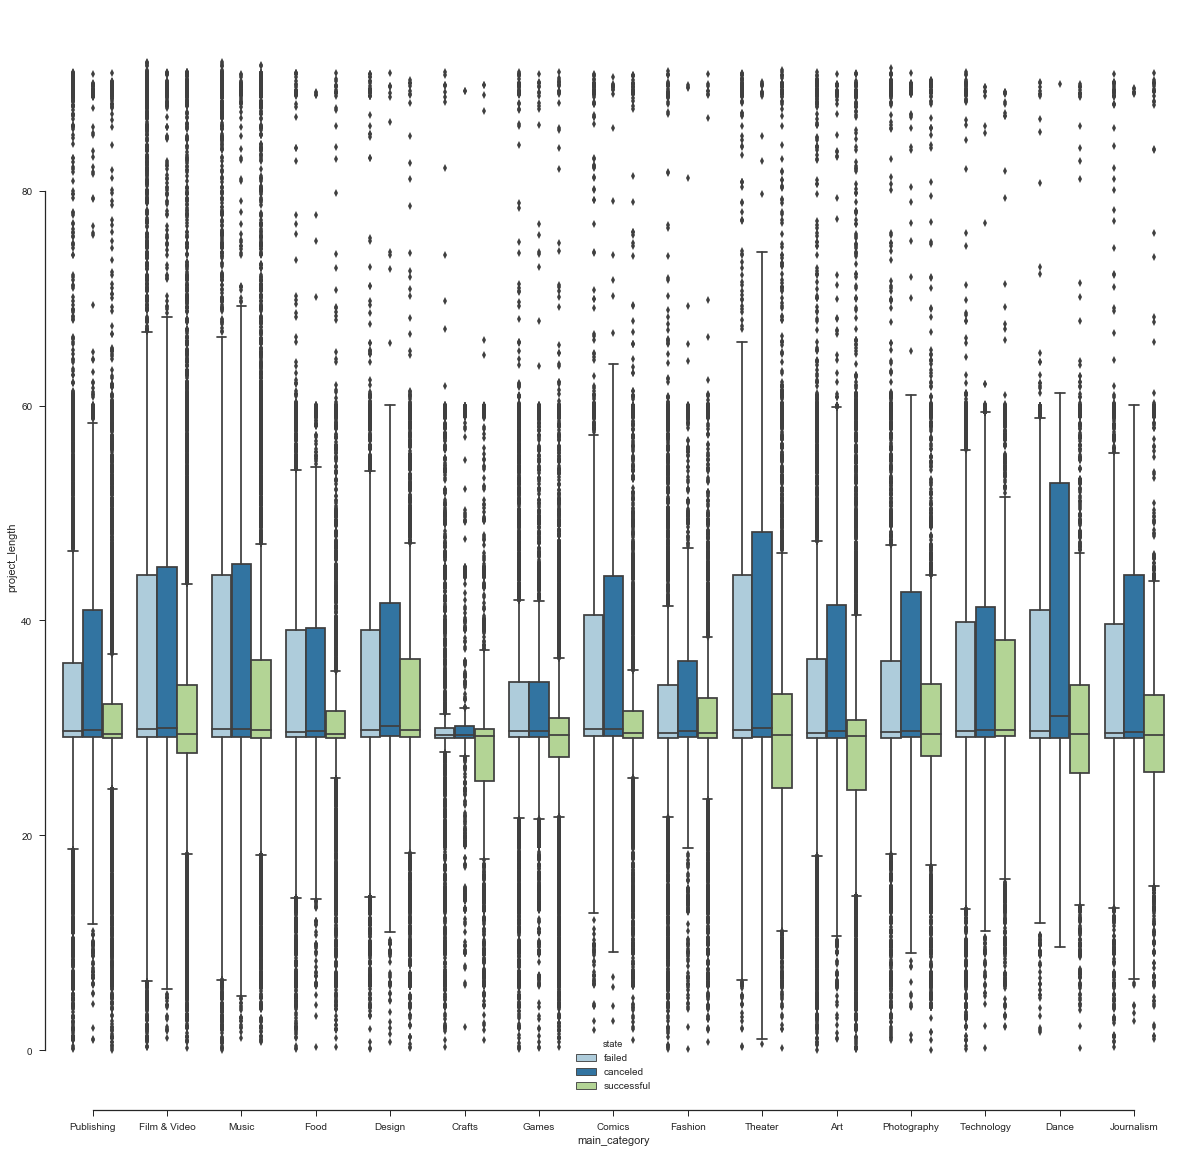

In [56]:
plt.figure(figsize=(20,20))
sns.set(style="ticks")
sns.boxplot(x="main_category", y="project_length", hue="state",data=ks, palette="Paired")
sns.despine(offset=10, trim=True)


We see the duration is shorter for successful projects in all categories. Still in this plot this is hard to compare, as we have different number of projects for each category. So, we have to normalize the data. 

## Temporal Analysis

In [ ]:
describe()